In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from safety_enforcer import SafetyEnforcer

/home/buzi/miniconda3/envs/spirit-rl-pybullet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = "data-20240104181500-0.5.pkl"
# pd.DataFrame(pd.read_pickle(filename)).to_csv("{}.csv".format(filename), index=False)
df = pd.DataFrame(pd.read_pickle(filename))

In [3]:
ep = float(filename.split("-")[-1].replace(".pkl", ""))

In [4]:
print(df.columns)

Index(['time', 'state', 'action', 'is_shielded', 'command', 'q_array'], dtype='object')


In [5]:
time_shield_on = []
time_is_shielded = []
time_no_shield = []

freq_shield_on = []
freq_is_shielded = []
freq_no_shield = []

for i in range(1, len(df)):
    if df.iloc[i]["command"] == "8s":
        if df.iloc[i]["is_shielded"] is True:
            time_is_shielded.append(df.iloc[i]["time"])
            freq_is_shielded.append(1.0 / (df.iloc[i]["time"] - df.iloc[i-1]["time"]))
        else:
            time_shield_on.append(df.iloc[i]["time"])
            freq_shield_on.append(1.0 / (df.iloc[i]["time"] - df.iloc[i-1]["time"]))
    else:
        time_no_shield.append(df.iloc[i]["time"])
        freq_no_shield.append(1.0 / (df.iloc[i]["time"] - df.iloc[i-1]["time"]))


/tmp/ipykernel_391238/453747960.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  freq_no_shield.append(1.0 / (df.iloc[i]["time"] - df.iloc[i-1]["time"]))
/tmp/ipykernel_391238/453747960.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  freq_shield_on.append(1.0 / (df.iloc[i]["time"] - df.iloc[i-1]["time"]))


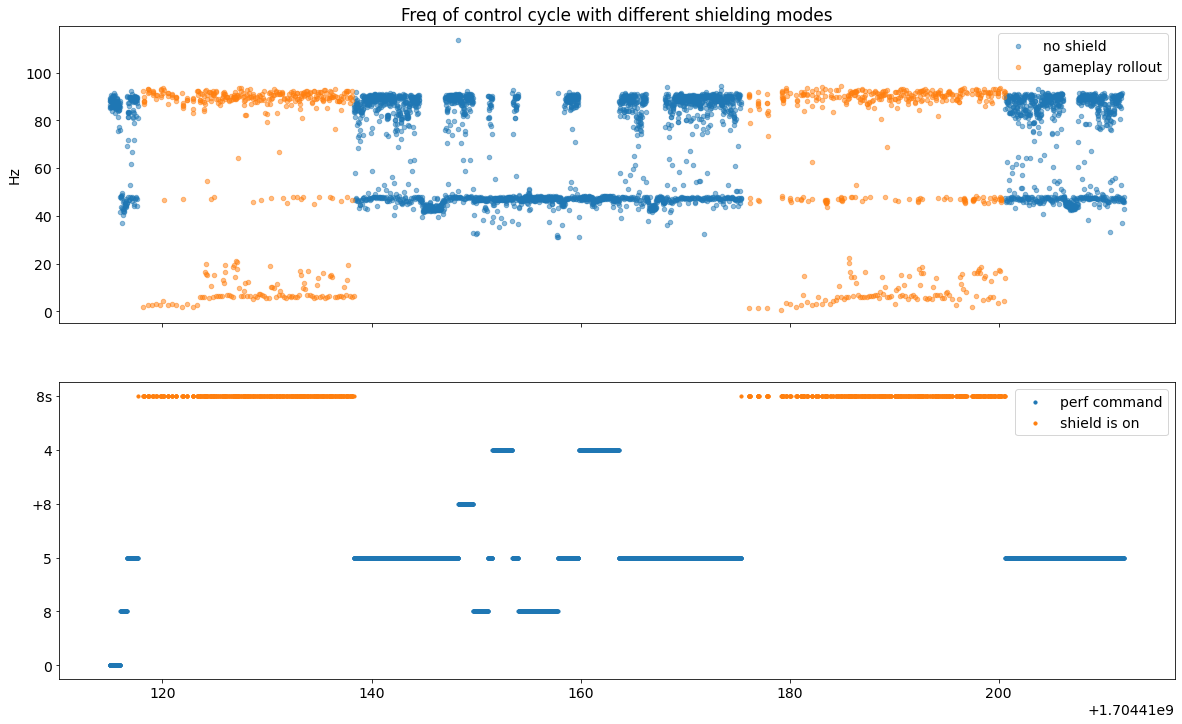

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
plt.rcParams.update({'font.size': 14})
ax[0].set_title("Freq of control cycle with different shielding modes")
ax[0].scatter(time_no_shield, freq_no_shield, label="no shield", alpha=0.5, s=20)
ax[0].scatter(time_shield_on, freq_shield_on, label="gameplay rollout", zorder=5, alpha=0.5, s=20)
# ax[0].scatter(time_is_shielded, freq_is_shielded, label="is shielded", zorder=10, alpha=0.8, s=50)
ax[1].scatter(df["time"][df["command"] != "8s"], df["command"][df["command"] != "8s"], s=10, label="perf command")
ax[1].scatter(df["time"][df["command"] == "8s"], df["command"][df["command"] == "8s"], s=10, label="shield is on")
# ax[2].plot(df["time"], df["q_array"], color="green", label="q array")
# ax[2].axhline(ep, color="red", alpha=0.5, label="epsilon")
ax[0].set_ylabel("Hz")
ax[0].legend()
ax[1].legend()
# ax[2].legend()
plt.show()

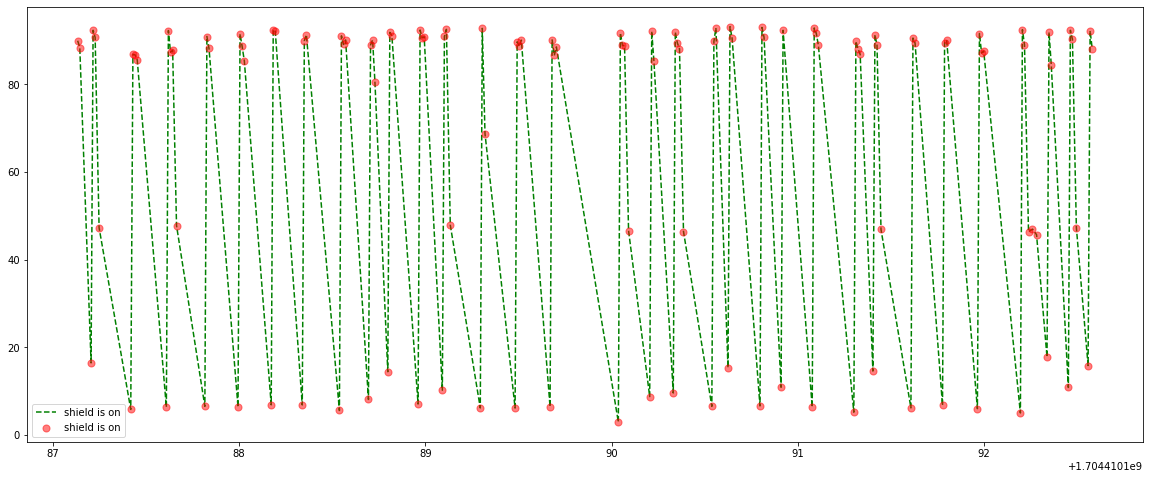

In [7]:
lim_low = 580
lim_high = 700

plt.figure(figsize=(20, 8))
plt.plot(time_shield_on[lim_low:lim_high], freq_shield_on[lim_low:lim_high], label="shield is on", color="green", ls="--")
plt.scatter(time_shield_on[lim_low:lim_high], freq_shield_on[lim_low:lim_high], label="shield is on", zorder=5, alpha=0.5, s=50, color="red")
plt.legend()
plt.show()

In [8]:
"""
x, y, z,
v_x, v_y, v_z,
roll, pitch, yaw,
ang_vel_x, ang_vel_y, ang_vel_z, 
joint_pos
joint_vel
"""
state_array = np.array(df["state"].to_list())
action_array = np.array(df["action"].to_list())
action_array = action_array.reshape((len(action_array), 4, 3))
action_array[:, :, [0, 1]] = action_array[:, :, [1, 0]]
action_array = action_array.reshape((len(action_array), 12))

In [9]:
action_array[100]

array([-0.07299888,  0.68581026,  1.64161919, -0.08735663,  1.0827522 ,
        1.33689207,  0.08735663,  1.0827522 ,  1.33689207,  0.07299888,
        0.68581026,  1.64161919])

In [10]:
state_array[100,12:24]

array([-0.009     ,  0.84799999,  1.55299997, -0.067     ,  0.75300002,
        1.35300004,  0.073     ,  0.73400003,  1.398     , -0.008     ,
        0.88499999,  1.48800004])

In [11]:
shielding_status = np.array([1 if x is True else 0 for x in df["is_shielded"]])
shielding_command = np.array([1 if x == "8s" else 0 for x in df["command"]])

In [12]:
lim_low = 2000
lim_high = 3200

q_array = df["q_array"].iloc[lim_low:lim_high].to_list()
shade_shield = []

for i in range(lim_low, lim_high):
    if q_array[i - lim_low] > ep:
        shade_shield.append(i)

shade_shield_cluster = []
start = shade_shield[0]
next_start = None
for i in range(len(shade_shield)):
    stop = None
    try:
        if shade_shield[i+1] - shade_shield[i] > 1:
            stop = shade_shield[i]
            next_start = shade_shield[i+1]
    except:
        stop = shade_shield[-1]

    if start is not None and stop is not None:
        shade_shield_cluster.append((start, stop))
        start = next_start

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
# ax[0].plot(df["time"], state_array[:, 6], label="roll")
# ax[0].plot(df["time"], state_array[:, 7], label="pitch")
# ax[0].plot(df["time"], shielding_command * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(df["time"], shielding_status * 0.2, label="shielding status", color="red", alpha=0.5)
# ax[1].plot(df["time"], df["q_array"], label="q value", color="green")

ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high, 6], label="roll")
ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high:, 7], label="pitch")
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_command[lim_low:lim_high] * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_status[lim_low:lim_high] * 0.2, label="shielding status", color="red", alpha=0.5)
for cluster in shade_shield_cluster:
    ax[0].axvspan(cluster[0]-0.5, cluster[1]+0.5, facecolor='g', alpha=0.1)
ax[1].plot(np.arange(lim_low, lim_high, 1), q_array, label="q value", color="green")

ax[0].axhline(ep, color="green", alpha=0.5, label="origin")
ax[1].axhline(ep, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [13]:
lim_low = 0
lim_high = len(df)

q_array = df["q_array"].iloc[lim_low:lim_high].to_list()
shade_shield = []

for i in range(lim_low, lim_high):
    if q_array[i - lim_low] > ep:
        shade_shield.append(i)

shade_shield_cluster = []
start = shade_shield[0]
next_start = None
for i in range(len(shade_shield)):
    stop = None
    try:
        if shade_shield[i+1] - shade_shield[i] > 1:
            stop = shade_shield[i]
            next_start = shade_shield[i+1]
    except:
        stop = shade_shield[-1]

    if start is not None and stop is not None:
        shade_shield_cluster.append((start, stop))
        start = next_start

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
# ax[0].plot(df["time"], state_array[:, 6], label="roll")
# ax[0].plot(df["time"], state_array[:, 7], label="pitch")
# ax[0].plot(df["time"], shielding_command * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(df["time"], shielding_status * 0.2, label="shielding status", color="red", alpha=0.5)
# ax[1].plot(df["time"], df["q_array"], label="q value", color="green")

ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high, 6], label="roll")
ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high:, 7], label="pitch")
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_command[lim_low:lim_high] * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_status[lim_low:lim_high] * 0.2, label="shielding status", color="red", alpha=0.5)
for cluster in shade_shield_cluster:
    ax[0].axvspan(cluster[0]-0.5, cluster[1]+0.5, facecolor='g', alpha=0.1)
ax[1].plot(np.arange(lim_low, lim_high, 1), q_array, label="q value", color="green")

ax[0].axhline(ep, color="green", alpha=0.5, label="origin")
ax[1].axhline(ep, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

TypeError: '>' not supported between instances of 'NoneType' and 'float'

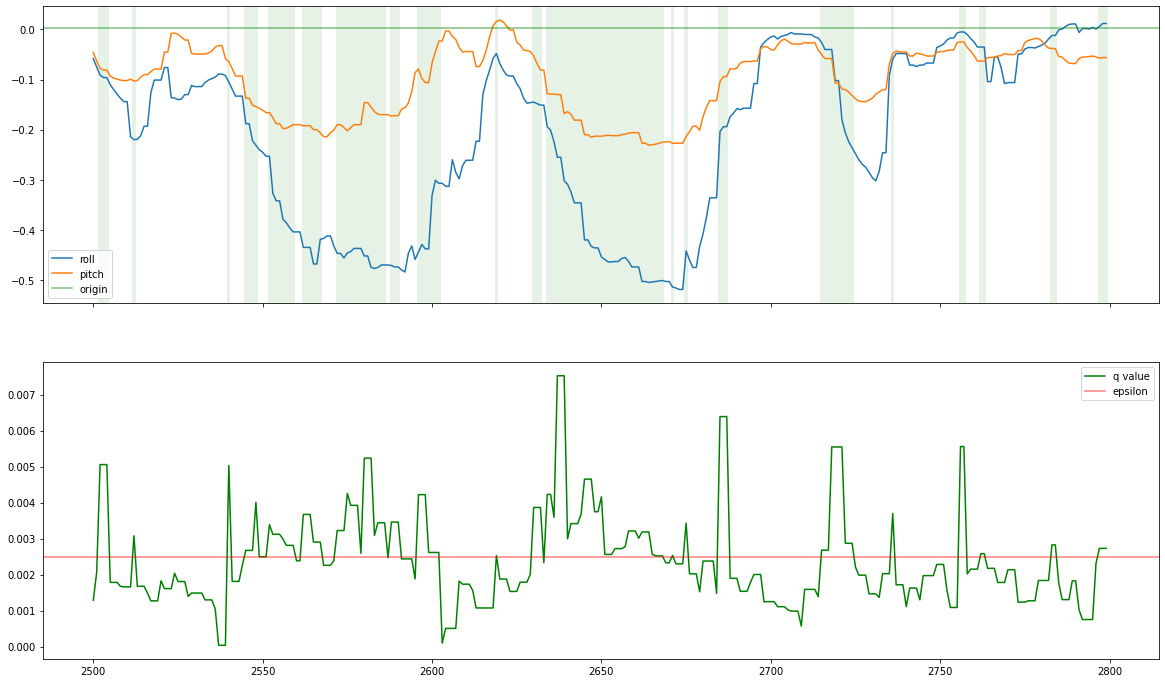

In [47]:
lim_low = 2500
lim_high = 2800

q_array = df["q_array"].iloc[lim_low:lim_high].to_list()
shade_shield = []

for i in range(lim_low, lim_high):
    if q_array[i - lim_low] > ep:
        shade_shield.append(i)

shade_shield_cluster = []
start = shade_shield[0]
next_start = None
for i in range(len(shade_shield)):
    stop = None
    try:
        if shade_shield[i+1] - shade_shield[i] > 1:
            stop = shade_shield[i]
            next_start = shade_shield[i+1]
    except:
        stop = shade_shield[-1]

    if start is not None and stop is not None:
        shade_shield_cluster.append((start, stop))
        start = next_start

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
# ax[0].plot(df["time"], state_array[:, 6], label="roll")
# ax[0].plot(df["time"], state_array[:, 7], label="pitch")
# ax[0].plot(df["time"], shielding_command * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(df["time"], shielding_status * 0.2, label="shielding status", color="red", alpha=0.5)
# ax[1].plot(df["time"], df["q_array"], label="q value", color="green")

ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high, 6], label="roll")
ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high:, 7], label="pitch")
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_command[lim_low:lim_high] * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_status[lim_low:lim_high] * 0.2, label="shielding status", color="red", alpha=0.5)
for cluster in shade_shield_cluster:
    ax[0].axvspan(cluster[0]-0.5, cluster[1]+0.5, facecolor='g', alpha=0.1)
ax[1].plot(np.arange(lim_low, lim_high, 1), q_array, label="q value", color="green")

ax[0].axhline(ep, color="green", alpha=0.5, label="origin")
ax[1].axhline(ep, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

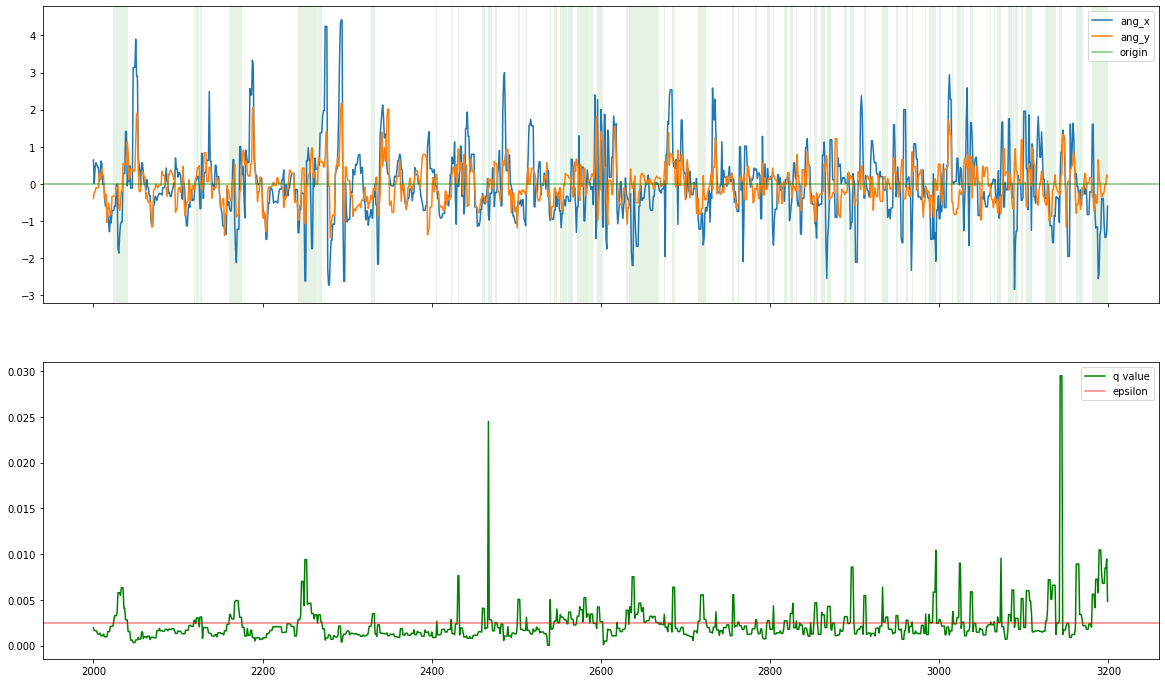

In [46]:
lim_low = 2000
lim_high = 3200

q_array = df["q_array"].iloc[lim_low:lim_high].to_list()
shade_shield = []

for i in range(lim_low, lim_high):
    if q_array[i - lim_low] > ep:
        shade_shield.append(i)

shade_shield_cluster = []
start = shade_shield[0]
next_start = None
for i in range(len(shade_shield)):
    stop = None
    try:
        if shade_shield[i+1] - shade_shield[i] > 1:
            stop = shade_shield[i]
            next_start = shade_shield[i+1]
    except:
        stop = shade_shield[-1]

    if start is not None and stop is not None:
        shade_shield_cluster.append((start, stop))
        start = next_start

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
# ax[0].plot(df["time"], state_array[:, 6], label="roll")
# ax[0].plot(df["time"], state_array[:, 7], label="pitch")
# ax[0].plot(df["time"], shielding_command * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(df["time"], shielding_status * 0.2, label="shielding status", color="red", alpha=0.5)
# ax[1].plot(df["time"], df["q_array"], label="q value", color="green")

ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high, 9], label="ang_x")
ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high:, 10], label="ang_y")
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_command[lim_low:lim_high] * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_status[lim_low:lim_high] * 0.2, label="shielding status", color="red", alpha=0.5)
for cluster in shade_shield_cluster:
    ax[0].axvspan(cluster[0]-0.5, cluster[1]+0.5, facecolor='g', alpha=0.1)
ax[1].plot(np.arange(lim_low, lim_high, 1), q_array, label="q value", color="green")

ax[0].axhline(ep, color="green", alpha=0.5, label="origin")
ax[1].axhline(ep, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

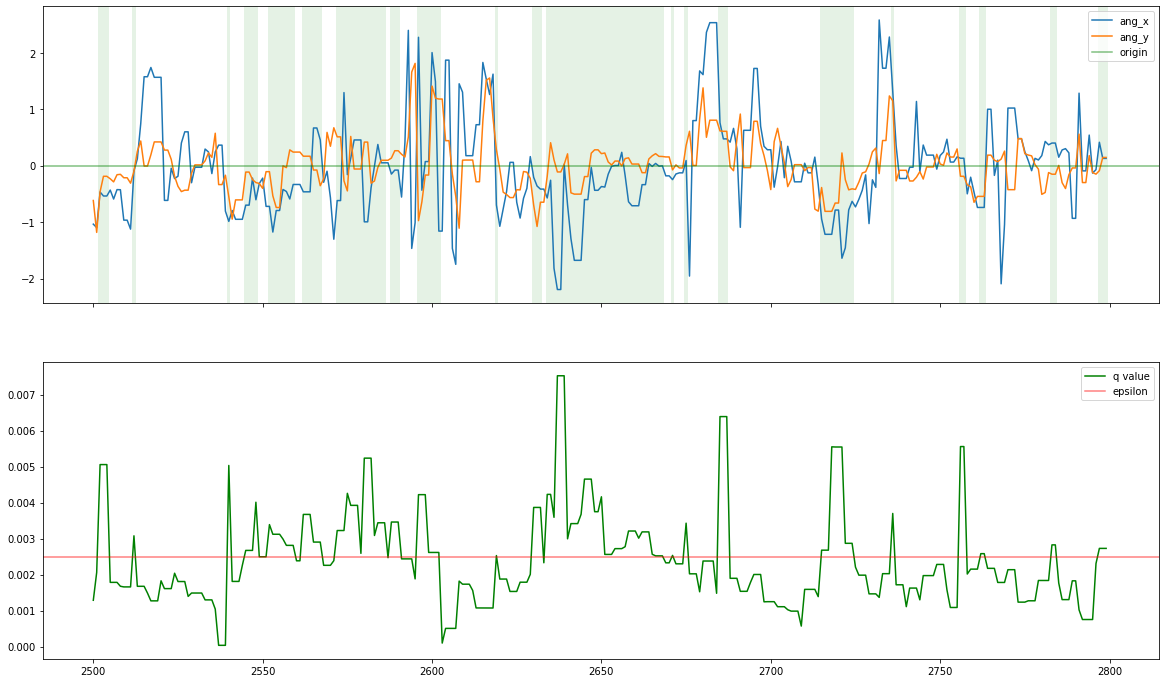

In [49]:
lim_low = 2500
lim_high = 2800

q_array = df["q_array"].iloc[lim_low:lim_high].to_list()
shade_shield = []

for i in range(lim_low, lim_high):
    if q_array[i - lim_low] > ep:
        shade_shield.append(i)

shade_shield_cluster = []
start = shade_shield[0]
next_start = None
for i in range(len(shade_shield)):
    stop = None
    try:
        if shade_shield[i+1] - shade_shield[i] > 1:
            stop = shade_shield[i]
            next_start = shade_shield[i+1]
    except:
        stop = shade_shield[-1]

    if start is not None and stop is not None:
        shade_shield_cluster.append((start, stop))
        start = next_start

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
# ax[0].plot(df["time"], state_array[:, 6], label="roll")
# ax[0].plot(df["time"], state_array[:, 7], label="pitch")
# ax[0].plot(df["time"], shielding_command * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(df["time"], shielding_status * 0.2, label="shielding status", color="red", alpha=0.5)
# ax[1].plot(df["time"], df["q_array"], label="q value", color="green")

ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high, 9], label="ang_x")
ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high:, 10], label="ang_y")
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_command[lim_low:lim_high] * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_status[lim_low:lim_high] * 0.2, label="shielding status", color="red", alpha=0.5)
for cluster in shade_shield_cluster:
    ax[0].axvspan(cluster[0]-0.5, cluster[1]+0.5, facecolor='g', alpha=0.1)
ax[1].plot(np.arange(lim_low, lim_high, 1), q_array, label="q value", color="green")

ax[0].axhline(ep, color="green", alpha=0.5, label="origin")
ax[1].axhline(ep, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

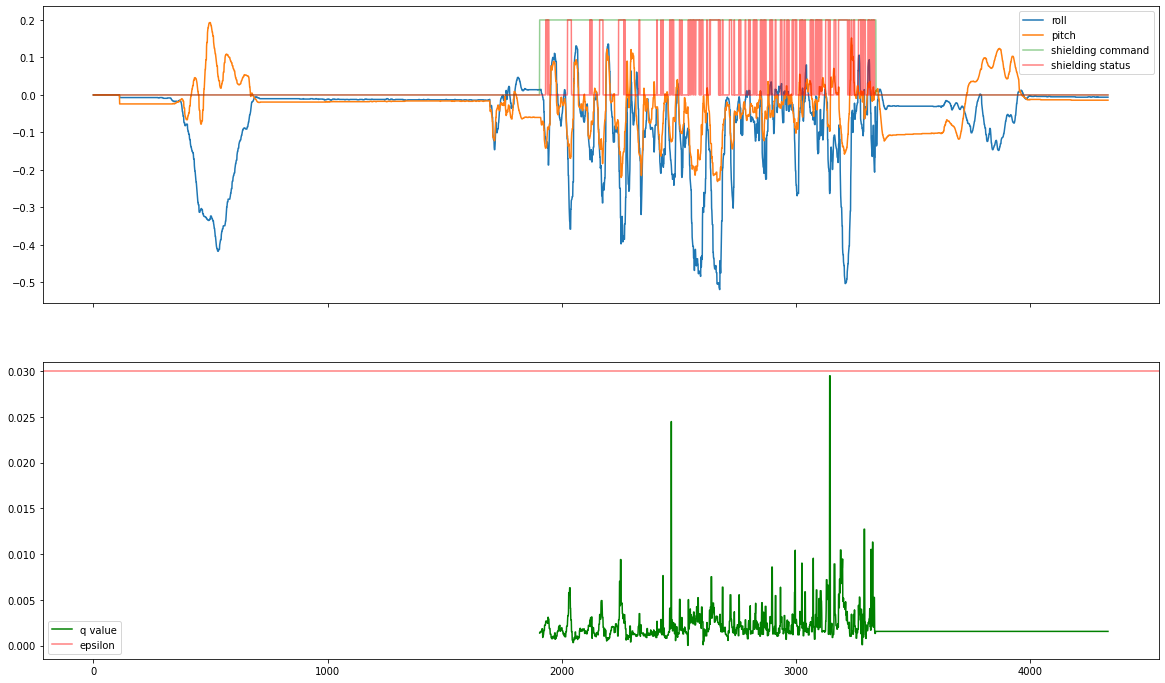

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
# ax[0].plot(df["time"], state_array[:, 6], label="roll")
# ax[0].plot(df["time"], state_array[:, 7], label="pitch")
# ax[0].plot(df["time"], shielding_command * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(df["time"], shielding_status * 0.2, label="shielding status", color="red", alpha=0.5)
# ax[1].plot(df["time"], df["q_array"], label="q value", color="green")

ax[0].plot(state_array[:, 6], label="roll")
ax[0].plot(state_array[:, 7], label="pitch")
ax[0].plot(shielding_command * 0.2, label="shielding command", alpha=0.5)
ax[0].plot(shielding_status * 0.2, label="shielding status", color="red", alpha=0.5)
ax[1].plot(df["q_array"], label="q value", color="green")

ax[1].axhline(0.03, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

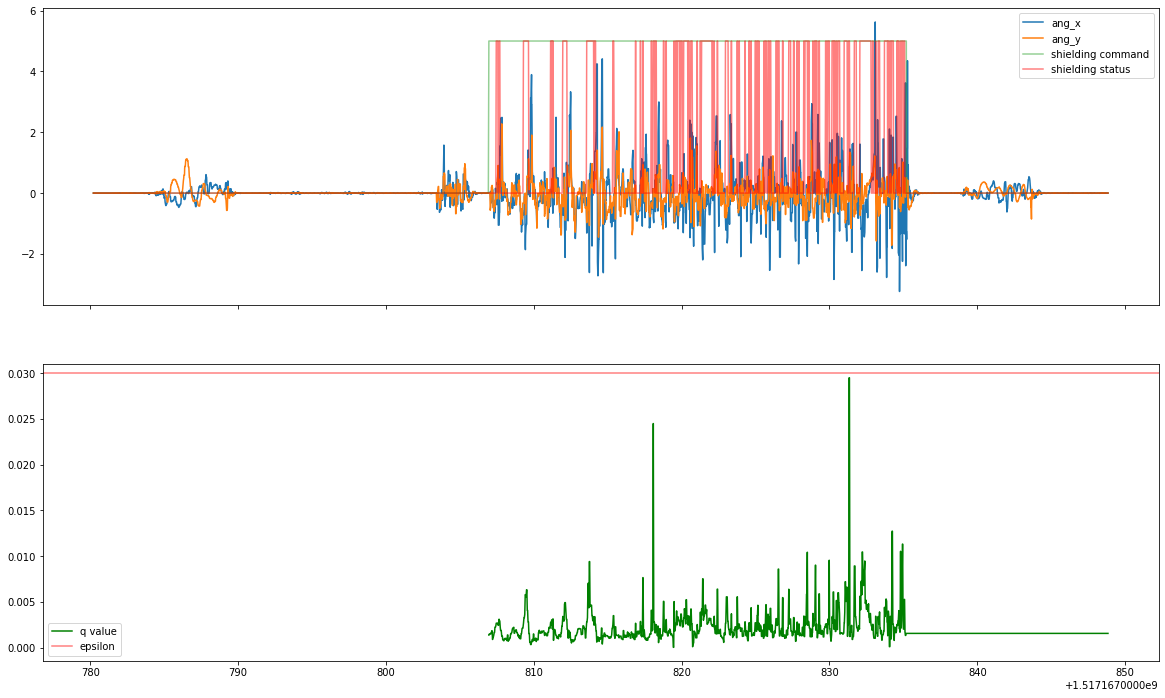

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax[0].plot(df["time"], state_array[:, 9], label="ang_x")
ax[0].plot(df["time"], state_array[:, 10], label="ang_y")
ax[0].plot(df["time"], shielding_command * 5, label="shielding command", alpha=0.5)
ax[0].plot(df["time"], shielding_status * 5, label="shielding status", color="red", alpha=0.5)
ax[1].plot(df["time"], df["q_array"], label="q value", color="green")
ax[1].axhline(0.03, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

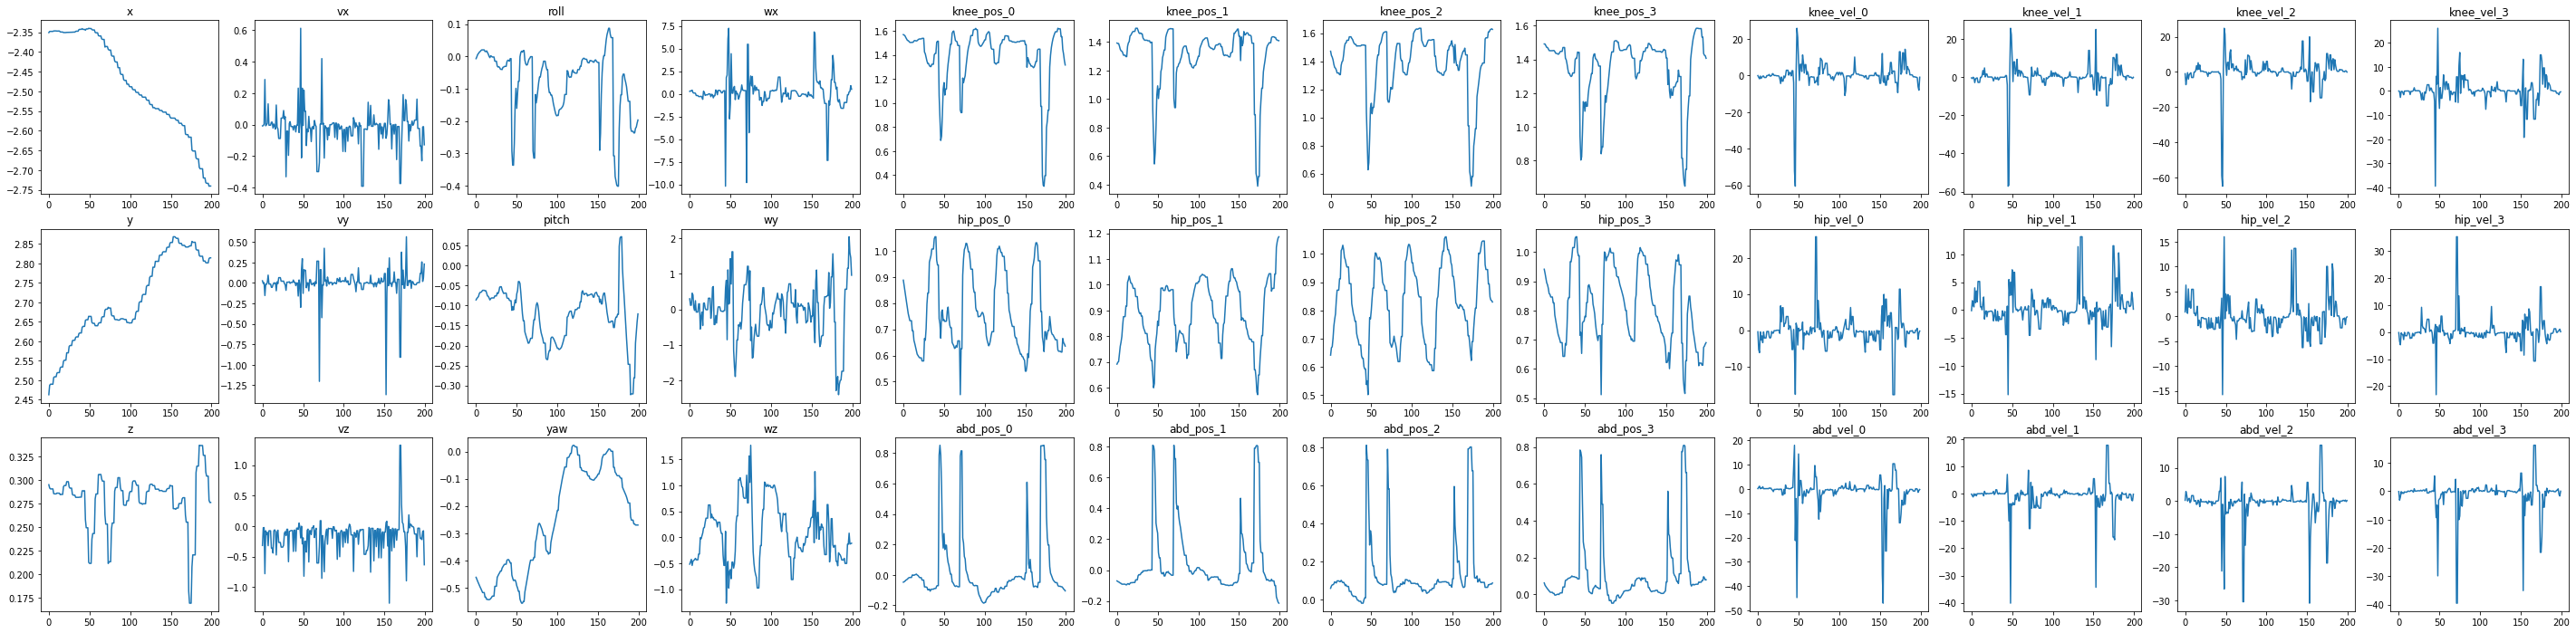

In [112]:
state_var_name = ["x", "y", "z", 
                  "vx", "vy", "vz", 
                  "roll", "pitch", "yaw", 
                  "wx", "wy", "wz",
                  "abd_pos_0", "hip_pos_0", "knee_pos_0",
                  "abd_pos_1", "hip_pos_1", "knee_pos_1",
                  "abd_pos_2", "hip_pos_2", "knee_pos_2",
                  "abd_pos_3", "hip_pos_3", "knee_pos_3",
                  "abd_vel_0", "hip_vel_0", "knee_vel_0",
                  "abd_vel_1", "hip_vel_1", "knee_vel_1",
                  "abd_vel_2", "hip_vel_2", "knee_vel_2",
                  "abd_vel_3", "hip_vel_3", "knee_vel_3"
                  ]
lim_low = 1000
lim_up = 1200

fig, ax = plt.subplots(3, 12, figsize=(50, 12))
for j in range(12):
    for i in range(3):
        ax[i][j].plot(state_array[lim_low:lim_up, j*3+i])
        ax[i][j].set_title(state_var_name[j*3+i])
plt.show()

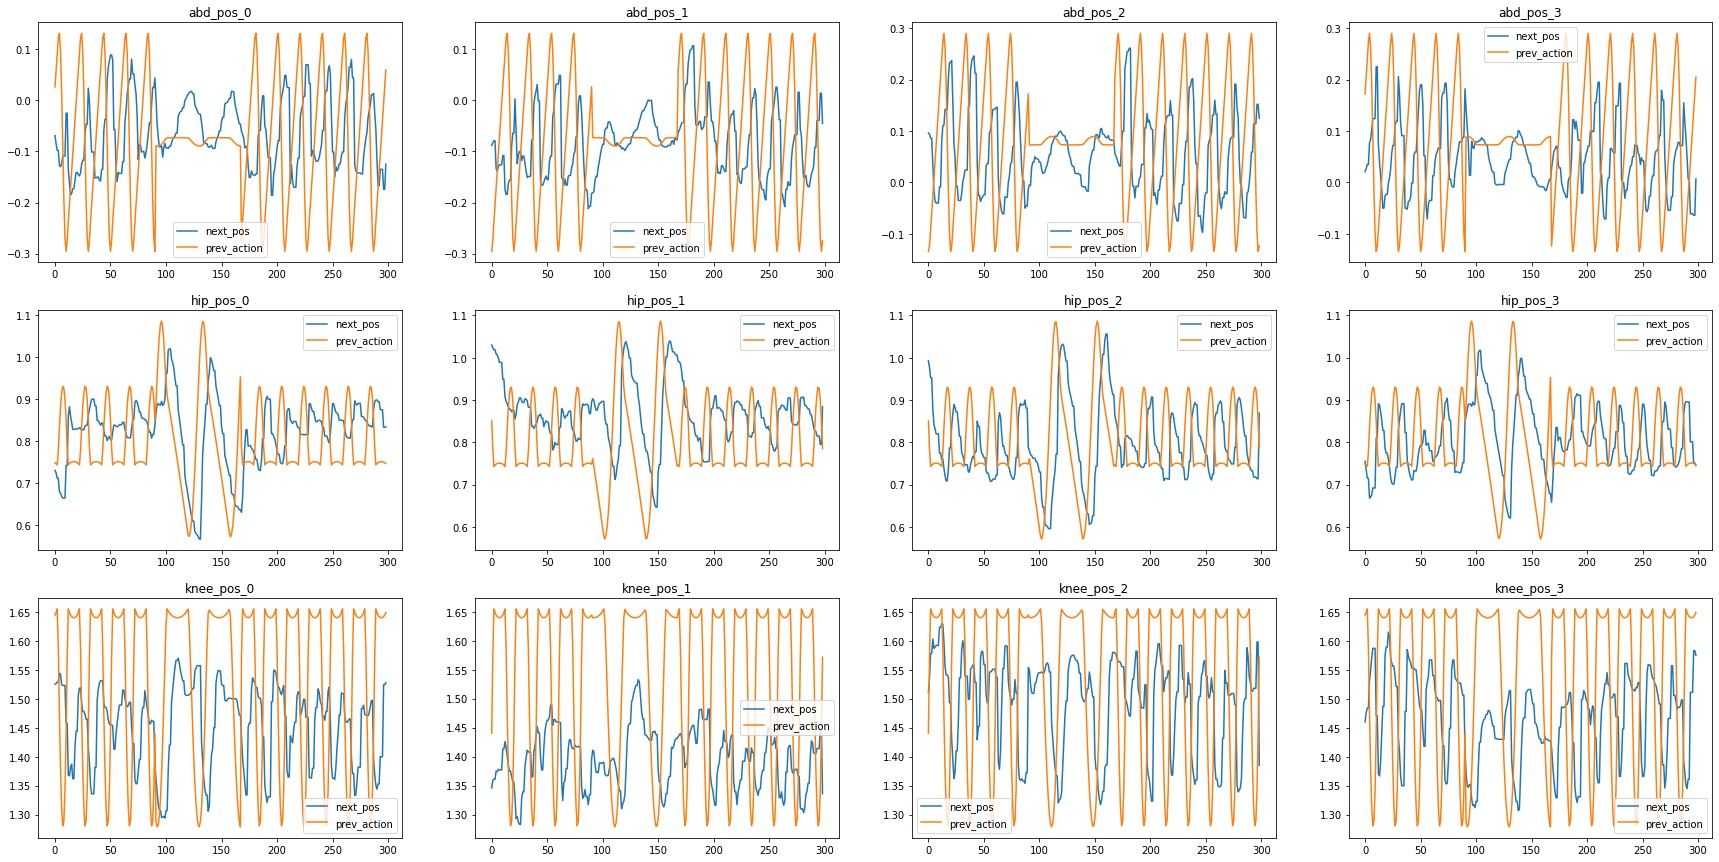

In [118]:
# check to see if prev_action = next_pos
lim_low = 600
lim_high = 900

prev_action = action_array[lim_low:lim_high-1, :]
next_pos = state_array[lim_low+1:lim_high, 12:24]

# next_pos = next_pos.reshape((len(next_pos), 4, 3))
# next_pos[:, :, [0, 1, 2]] = next_pos[:, :, [2, 1, 0]]
# next_pos = next_pos.reshape((len(next_pos), 12))

plot_name = [
    "abd_pos_0", "hip_pos_0", "knee_pos_0",
    "abd_pos_1", "hip_pos_1", "knee_pos_1", 
    "abd_pos_2", "hip_pos_2", "knee_pos_2",
    "abd_pos_3", "hip_pos_3", "knee_pos_3"
]

fig, ax = plt.subplots(3, 4, figsize=(30, 15))
for j in range(4):
    for i in range(3):
        ax[i][j].plot(next_pos[:, j*3+i], label="next_pos")
        ax[i][j].plot(prev_action[:, j*3+i], label="prev_action")
        ax[i][j].set_title(plot_name[j*3+i])
        ax[i][j].legend()
plt.show()

In [51]:
filename = "data-20180128110405-0.0025.pkl"
# pd.DataFrame(pd.read_pickle(filename)).to_csv("{}.csv".format(filename), index=False)
df = pd.DataFrame(pd.read_pickle(filename))
ep = float(filename.split("-")[-1].replace(".pkl", ""))

In [52]:
"""
x, y, z,
v_x, v_y, v_z,
roll, pitch, yaw,
ang_vel_x, ang_vel_y, ang_vel_z, 
joint_pos
joint_vel
"""
state_array = np.array(df["state"].to_list())
action_array = np.array(df["action"].to_list())
action_array = action_array.reshape((len(action_array), 4, 3))
action_array[:, :, [0, 1]] = action_array[:, :, [1, 0]]
action_array = action_array.reshape((len(action_array), 12))

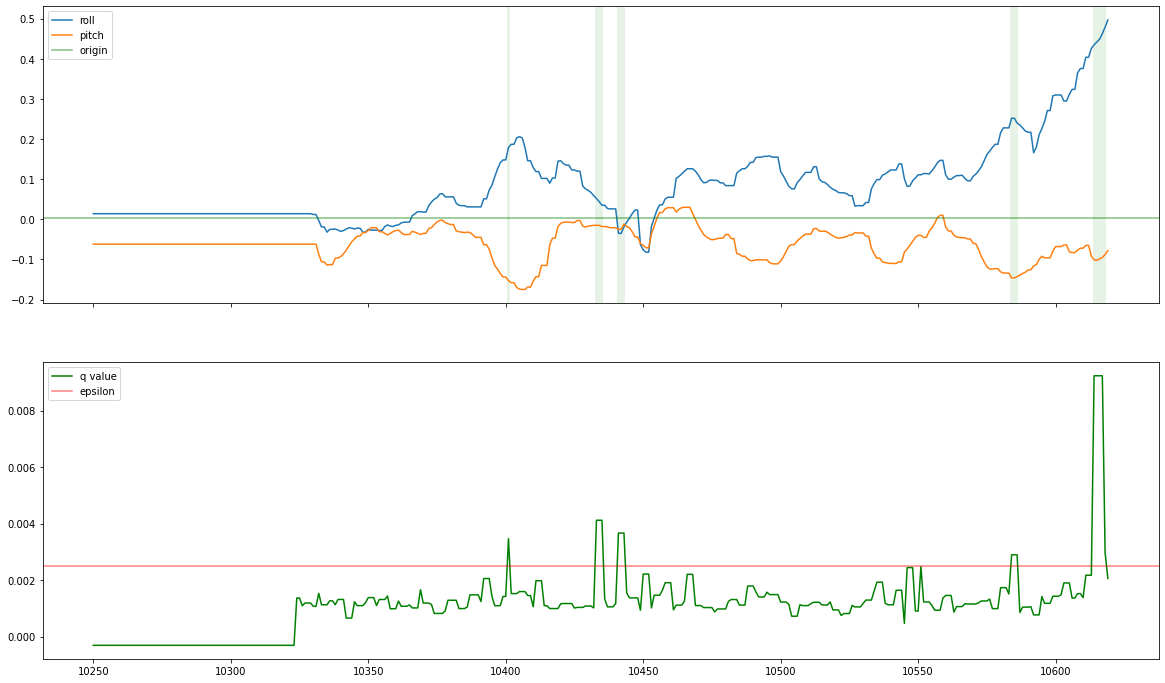

In [61]:
lim_low = 10_250
lim_high = 10_620

q_array = df["q_array"].iloc[lim_low:lim_high].to_list()
shade_shield = []

for i in range(lim_low, lim_high):
    if q_array[i - lim_low] > ep:
        shade_shield.append(i)

shade_shield_cluster = []
start = shade_shield[0]
next_start = None
for i in range(len(shade_shield)):
    stop = None
    try:
        if shade_shield[i+1] - shade_shield[i] > 1:
            stop = shade_shield[i]
            next_start = shade_shield[i+1]
    except:
        stop = shade_shield[-1]

    if start is not None and stop is not None:
        shade_shield_cluster.append((start, stop))
        start = next_start

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
# ax[0].plot(df["time"], state_array[:, 6], label="roll")
# ax[0].plot(df["time"], state_array[:, 7], label="pitch")
# ax[0].plot(df["time"], shielding_command * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(df["time"], shielding_status * 0.2, label="shielding status", color="red", alpha=0.5)
# ax[1].plot(df["time"], df["q_array"], label="q value", color="green")

ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high, 6], label="roll")
ax[0].plot(np.arange(lim_low, lim_high, 1), state_array[lim_low:lim_high:, 7], label="pitch")
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_command[lim_low:lim_high] * 0.2, label="shielding command", alpha=0.5)
# ax[0].plot(np.arange(lim_low, lim_high, 1), shielding_status[lim_low:lim_high] * 0.2, label="shielding status", color="red", alpha=0.5)
for cluster in shade_shield_cluster:
    ax[0].axvspan(cluster[0]-0.5, cluster[1]+0.5, facecolor='g', alpha=0.1)
ax[1].plot(np.arange(lim_low, lim_high, 1), q_array, label="q value", color="green")

ax[0].axhline(ep, color="green", alpha=0.5, label="origin")
ax[1].axhline(ep, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

In [70]:
from safety_enforcer import SafetyEnforcer

In [71]:
"""
x, y, z,
v_x, v_y, v_z,
roll, pitch, yaw,
ang_vel_x, ang_vel_y, ang_vel_z, 
joint_pos
joint_vel
"""

stable_stance = np.array([
    0.9, -0.07, 1.6,
    0.9, -0.07, 1.6,
    0.9, 0.07, 1.6,
    0.9, 0.07, 1.6
])

roll = 0

action = np.zeros(12)

def get_state(roll):
    return np.concatenate((
        np.array([0, 0, 0, 0, 0, 0, roll, 0, 0, 0, 0, 0]),
        stable_stance, 
        np.zeros(12)
    ), axis=0, dtype=np.float32)

In [72]:
safetyEnforcer = SafetyEnforcer(0.0)

The neural networks for CRITIC have the architecture as below:
ModuleList(
  (0): Sequential(
    (linear_1): Linear(in_features=54, out_features=128, bias=True)
    (act_1): Sin()
  )
  (1): Sequential(
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (act_1): Sin()
  )
  (2): Sequential(
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (act_1): Sin()
  )
  (3): Sequential(
    (linear_1): Linear(in_features=128, out_features=1, bias=True)
    (act_1): Identity()
  )
)

The actor shares the same encoder with the critic.
The neural network for MEAN has the architecture as below:
ModuleList(
  (0): Sequential(
    (linear_1): Linear(in_features=36, out_features=256, bias=True)
    (act_1): Sin()
  )
  (1): Sequential(
    (linear_1): Linear(in_features=256, out_features=256, bias=True)
    (act_1): Sin()
  )
  (2): Sequential(
    (linear_1): Linear(in_features=256, out_features=256, bias=True)
    (act_1): Sin()
  )
  (3): Sequential(
   

In [74]:
safetyEnforcer.get_action(get_state(roll=0.0), action)
print(safetyEnforcer.prev_q)

0.004321387


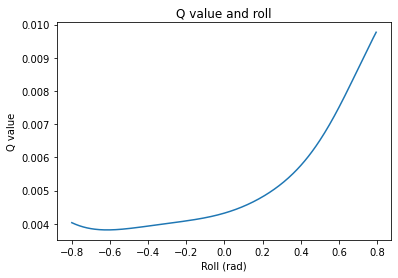

In [89]:
plt.figure(0)
plt.title("Q value and roll")
q_array = []
for i in np.arange(-0.8, 0.8, 0.005):
    safetyEnforcer.get_action(get_state(roll=i), action)
    q_array.append(safetyEnforcer.prev_q)
plt.plot(np.arange(-0.8, 0.8, 0.005), q_array)
plt.xlabel("Roll (rad)")
plt.ylabel("Q value")
plt.show()

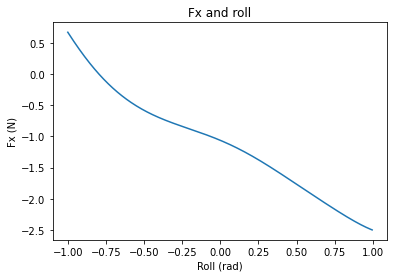

In [100]:
plt.figure(0)
plt.title("Fx and roll")
f_x_array = []
for i in np.arange(-1.0, 1.0, 0.005):
    state = get_state(roll=i)
    s_dstb = np.concatenate((state, action), axis=0)
    dstb = safetyEnforcer.policy.dstb(s_dstb)
    f_x_array.append(dstb[0] * 5.0)
plt.plot(np.arange(-1.0, 1.0, 0.005), f_x_array)
plt.xlabel("Roll (rad)")
plt.ylabel("Fx (N)")
plt.show()

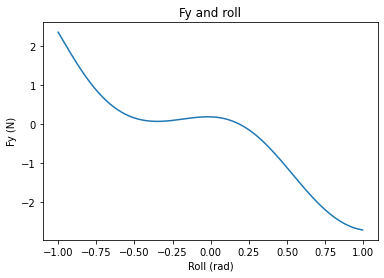

In [97]:
plt.figure(0)
plt.title("Fy and roll")
f_y_array = []
for i in np.arange(-1.0, 1.0, 0.005):
    state = get_state(roll=i)
    s_dstb = np.concatenate((state, action), axis=0)
    dstb = safetyEnforcer.policy.dstb(s_dstb)
    f_y_array.append(dstb[1] * 5.0)
plt.plot(np.arange(-1.0, 1.0, 0.005), f_y_array)
plt.xlabel("Roll (rad)")
plt.ylabel("Fy (N)")
plt.show()

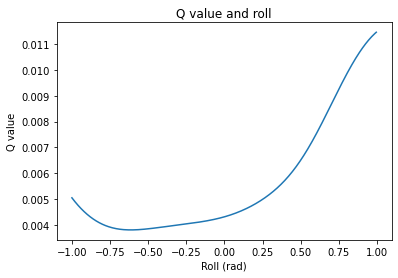

In [98]:
plt.figure(0)
plt.title("Q value and roll")
q_array = []
for i in np.arange(-1.0, 1.0, 0.005):
    safetyEnforcer.get_action(get_state(roll=i), action)
    q_array.append(safetyEnforcer.prev_q)
plt.plot(np.arange(-1.0, 1.0, 0.005), q_array)
plt.xlabel("Roll (rad)")
plt.ylabel("Q value")
plt.show()

In [99]:
action

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])